# Part III of "Introduction to Text and Image Analysis Using Python (DHNB 2022)"

workshop website: [https://raphaelaheil.github.io/2022-03-15-dhnb/](https://raphaelaheil.github.io/2022-03-15-dhnb/)

Dataset information: 
> "DIDA is a new image-based historical handwritten digit dataset and collected from the Swedish historical handwritten document images between the year 1800 and 1940"

>A Deep Handwritten Digit Detection and Recognition Method Using a New Historical Handwritten Digit Dataset, Huseyin Kusetogullari, Amir Yavariabdi, Johan Hall, Niklas Lavesson,
DIGITNET: 
Big Data Research,
Volume 23,
2021,
100182,
ISSN 2214-5796,
https://doi.org/10.1016/j.bdr.2020.100182.
(https://www.sciencedirect.com/science/article/pii/S2214579620300502)

Original dataset download: [https://didadataset.github.io/DIDA/](https://didadataset.github.io/DIDA/)

Workshop dataset download: [https://uppsala.box.com/s/5rw2orqsbfmiwmuw5607vbg1eknw2k18](https://uppsala.box.com/s/5rw2orqsbfmiwmuw5607vbg1eknw2k18)

_For usability reasons, the original dataset has been restructured and compressed as a *.zip, instead of *.rar for the purpose of the workshop. The data itself however remains unchanged._

---

Before we can dive in, we have to import some packages, so that Python has access to certain functionalities: 

In [18]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import utils

Brief introduction of the main packages:

**Matplotlib**
> Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
>
> from [https://matplotlib.org/](https://matplotlib.org/)

Documentation: [https://matplotlib.org/stable/api/index](https://matplotlib.org/stable/api/index)

Extensive gallery of examples: [https://matplotlib.org/stable/gallery/index.html](https://matplotlib.org/stable/gallery/index.html)

**Numpy**
> "NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more." 
>
> from [https://numpy.org/](https://numpy.org/)

Documentation: [https://numpy.org/doc/stable/reference/index.html#reference](https://numpy.org/doc/stable/reference/index.html#reference)

**Skimage (scikit-image)**
> "scikit-image is a collection of algorithms for image processing."
>
> from [https://scikit-image.org/](https://scikit-image.org/)

Documentation: [https://scikit-image.org/docs/stable/api/api.html](https://scikit-image.org/docs/stable/api/api.html)

Gallery of examples: [https://scikit-image.org/docs/stable/auto_examples/index.html](https://scikit-image.org/docs/stable/auto_examples/index.html)

**Sklearn (scikit-learn)**
> "Simple and efficient tools for predictive data analysis."
> 
> from [https://scikit-learn.org/](https://scikit-learn.org/)

Documentation: [https://scikit-learn.org/stable/modules/classes.html](https://scikit-learn.org/stable/modules/classes.html)

User guide: [https://scikit-learn.org/stable/user_guide.html](https://scikit-learn.org/stable/user_guide.html)

---

**TODO**: Introduction of the task, i.e. cluster digits and annotate them in bulk, to speed things up (compare: annotation of each digit individually, vs dozens of examples of the digit '0' at once)

Bigger picture: cluster words or other things and quickly annotate them in bulk 

Caveat: not super precise (as we will see below) but can be a decent starting point, e.g. for deep learning, where annotated training data is often the bottleneck

---

Let's start by downloading the data. 

*If you have already downloaded it, you can skip the following cell. Instead, extract the downloaded archive and place the folder "dida_single_digit_10k" in the same place as this notebook.*

In [19]:
utils.retrieve_dhnb_images()

Successfully donwloaded dataset!


Next, we will load the images into our notebook, so that we can work with them:

In [2]:
images, labels = utils.read_all_images(images_per_digit=10)

Loaded 100 images from: dida_single_digit_10k


## The Data

Let's look at the first 100 images in our dataset. The images are of different widths and heights, we therefore have to normalise them, in order to visualise them nicely. In this example, we scale all images to the same height of 64 pixels, while maintaining the aspect ratio. If the resulting width is smaller than 100, we fill the rest of the image with a white background. If it is wider than 100, we will cut off the rest. 

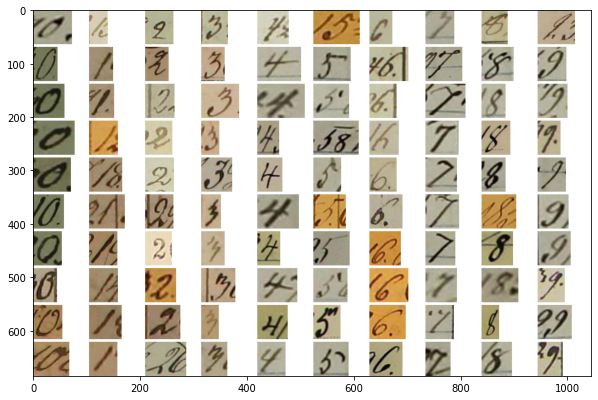

In [27]:
rescaled = []
for img in images[:100]:
    rescaled.append(utils.scale_and_pad(img, (64, 100)))
result = utils.digit_grid(rescaled)
fig = plt.figure(figsize=(10, 10))
plt.imshow(result)

Let's inspect what our labels look like: 

In [22]:
print("Number of retrieved labels:", len(labels))

Number of retrieved labels: 100


In [23]:
print("List of retrieved labels:", labels)

List of retrieved labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [24]:
print("List of unique labels:", np.unique(labels))

List of unique labels: [0 1 2 3 4 5 6 7 8 9]


## Data Pre-Processing

As we saw in the digit image visualisation above, there is quite a range of different shapes, colours and hues present in the dataset. Some of these aspects can hinder the classification. We therefore pre-process the images below, to normalise some of the aspects of the data that are not relevant, or even detrimental, to our task.

In the first step, we resize all images to a fixed width and height of 64 pixels. Where necessary, the image will be stretched or squashed, to fit into this shape. Afterwards, we remove the colour information, so that only a greyscale image is retained. 

The choice of size is, to some degree, arbitrary. Smaller or larger images may work better or worse but it is a decent starting point, as many of the original images are similar to the chosen size. 

Feel free to come back to this cell and modify the line `resized = resize(image, (64,64))` with different dimensions and see what impact it has on the rest of the notebook. The first value in the parentheses denotes the height and the second the width, i.e. replace `height` and `width` in `resized = resize(image, (height,width))` with your chosen values. 

In [6]:
greyscale = []
for image in images:
    resized = resize(image, (64,64))
    grey = rgb2gray(resized)
    greyscale.append(grey)

Let's look at what the first 100 images currently look like: 

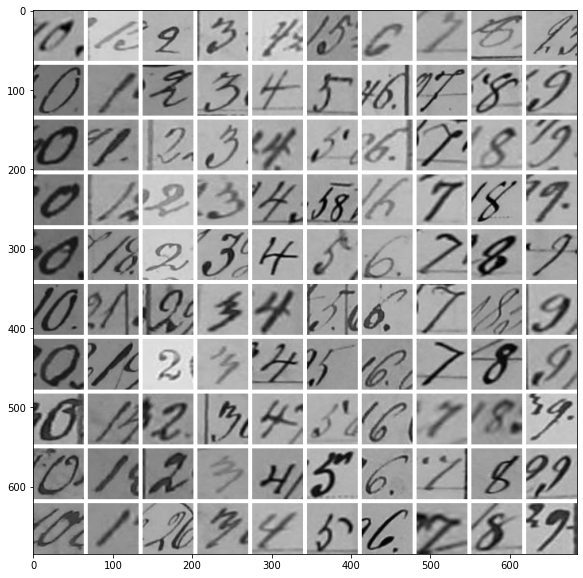

In [28]:
fig = plt.figure(figsize=(10,10))
plt.imshow(utils.digit_grid(greyscale[:100]), cmap="gray")

There is still quite a bit of variation in background and ink colour across the images. Since our goal is to identify the digits themselves, we will remove this information, so that the only thing that remains is which pixels are part of an ink-stroke and which are not. 

This is done via a process called "thresholding". Each pixel in the image has a value assigned to it that represents the colour, or in the greyscale case, how light/dark it is. We can define a threshold value to separate between light and dark areas in the image. Everything that is lighter than the threshold becomes white and everything that is darker becomes black. 

Below, we use a method called Otsu's thresholding, to determine which is the best cut-off point for each image, however we could also define this value manually, by replacing `thresholded = (grey_image>threshold_otsu(grey_image))*1.0` with `thresholded = (grey_image>manual_threshold)*1.0`, where `manual_threshold` is a value chosen by us.

Feel free to try out different manual thresholds (between 0 and 1) and see how they affect the images in the cell below, as well as the rest of the pipeline.

In [33]:
black_and_white = []
for grey_image in greyscale:
    thresholded = (grey_image>threshold_otsu(grey_image))*1.0
    black_and_white.append(thresholded)

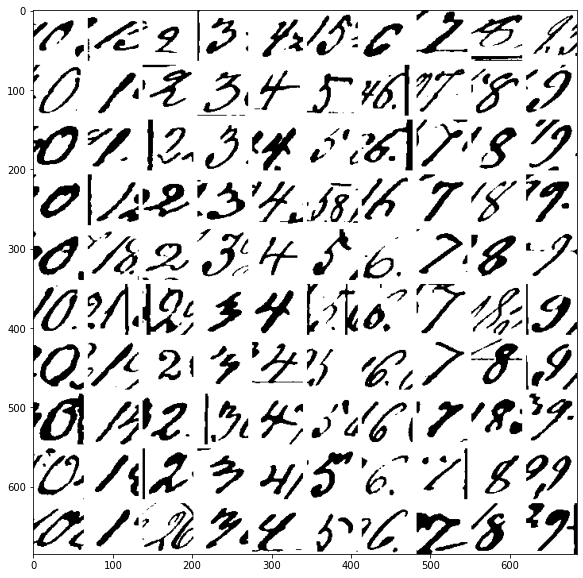

In [34]:
result = utils.digit_grid(black_and_white[:100], spacer=(5,5), spacer_value=1)
fig = plt.figure(figsize=(10,10))
plt.imshow(result, cmap="gray")
plt.savefig("test2.png")

## Feature Extraction

**TODO**


In [35]:
features = []
for bw_image in black_and_white:
    histogram_oriented_gradients = hog(bw_image)
    features.append(histogram_oriented_gradients)

## Clustering

**TODO**: we cluster in higher dim space, briefly explain kmeans

OBS: kmeans assigns an arbitrary number as label to each cluster, this is not related to the digits inside the cluster! alternatively, one could think of these kmeans cluster labels as "a", "b", "c", etc.

explain the two places to experiment: number of clusters and random state 

In [37]:
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(features)
print(cluster_labels)

[2 4 9 0 6 7 9 6 3 6 3 6 4 3 7 5 8 8 2 0 3 6 4 3 4 5 2 1 2 0 4 6 4 4 6 3 2
 2 2 6 3 6 9 3 7 5 2 1 0 6 3 8 0 0 7 8 5 1 2 0 3 1 9 0 4 5 2 1 2 0 3 6 4 4
 7 5 2 1 2 2 3 6 4 0 9 2 5 1 6 2 9 1 6 6 7 7 2 9 2 2]


**TODO**: let's look at what each cluster contains; we do so, by taking all images in the the respective cluster and calculating the average image. We call this a heatmap in this notebook, as it shows the areas where a lot of ink pixels overlap, respecitvely where hardly any pixels are 

(emphasised by the "hot" cmap below, though afterwards we switch back to b/w to stay with the ink theme)
maybe demo a couple of different cmap options, for fun

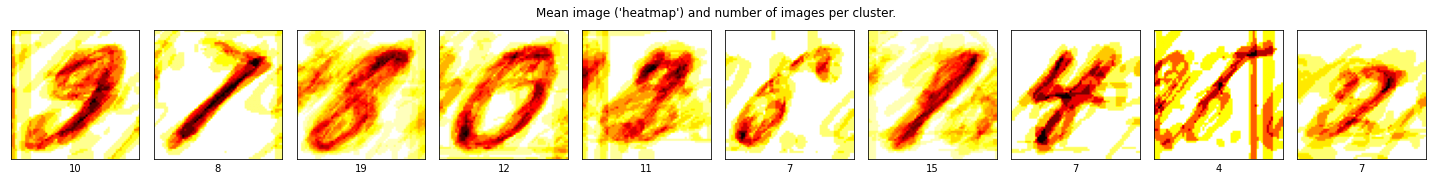

In [38]:
heatmaps = []

fig, ax = plt.subplots(ncols=len(np.unique(cluster_labels)), figsize = (20,10))

for cluster_id, axis in enumerate(ax):
    selected = np.array(black_and_white)[cluster_labels == cluster_id]
    meanImage = np.mean(selected, axis=0)
    heatmaps.append(meanImage)
    axis.imshow(meanImage, cmap="hot")
    
    axis.set_xlabel(len(selected))
    axis.set_xticks([])
    axis.set_yticks([])

fig.suptitle("Mean image ('heatmap') and number of images per cluster.")

fig.tight_layout()
fig.subplots_adjust(top=1.7)

**TODO** annotate each cluster, based on the heatmap image, i.e. whatever digit the mean image looks like to us will be used as label

explain how the cell below works and discuss what it means if we don't see an example for each digit 

In [39]:
tool, text_inputs = utils.annotation_view(heatmaps)
display(tool)

**TODO** Retrieve the manual classification from the widget above, so that we can use it in the mapping below:

In [41]:
manual_classification = []
for i in text_inputs:
    manual_classification.append(int(i.value))
print(manual_classification)

[9, 7, 8, 0, 4, 6, 1, 4, 5, 0]


**TODO** apply the cluster:digit mapping to all cluster_labels to create a full "human" classification of all digit images:

In [42]:
human_classification = np.zeros_like(cluster_labels) 
for cluster_index, digit in enumerate(manual_classification):
    human_classification[cluster_labels == cluster_index] = digit
print(human_classification)

[8 4 0 9 1 4 0 1 0 1 0 1 4 0 4 6 5 5 8 9 0 1 4 0 4 6 8 7 8 9 4 1 4 4 1 0 8
 8 8 1 0 1 0 0 4 6 8 7 9 1 0 5 9 9 4 5 6 7 8 9 0 7 0 9 4 6 8 7 8 9 0 1 4 4
 4 6 8 7 8 8 0 1 4 9 0 8 6 7 1 8 0 7 1 1 4 4 8 0 8 8]


**TODO:** evaluate the performance of the human classification with the ground truth labels that we have loaded with the data, to get an idea of how good we are

**TODO** give brief explanation of how a confusion matrix works and what the values in the classification report mean

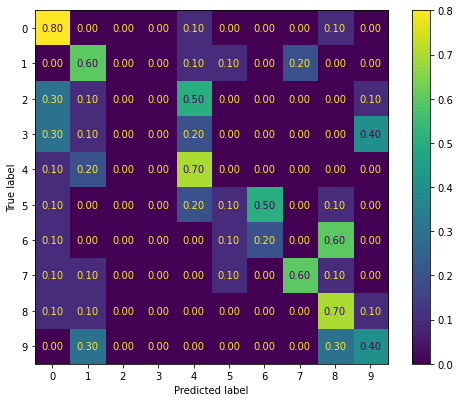

In [43]:
plt.figure(figsize=(8.8,6.5))
cm = confusion_matrix(labels, human_classification, labels=list(range(10)), normalize="true")
cmd = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
cmd.plot(ax=plt.gca(), values_format=".2f")

In [44]:
print(classification_report(labels, human_classification, labels=list(range(10)), zero_division=0))

              precision    recall  f1-score   support

           0       0.42      0.80      0.55        10
           1       0.40      0.60      0.48        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.39      0.70      0.50        10
           5       0.25      0.10      0.14        10
           6       0.29      0.20      0.24        10
           7       0.75      0.60      0.67        10
           8       0.37      0.70      0.48        10
           9       0.40      0.40      0.40        10

    accuracy                           0.41       100
   macro avg       0.33      0.41      0.35       100
weighted avg       0.33      0.41      0.35       100



**TODO** summarise the notebook and let learners explore some of the parameters, e.g. encourage them to explore the impact of different number of clusters -> how many clusters are still a feasible amount of annotation work vs the classification performance, how many clusters do we need at least? etc. 